## Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам было предложено построить модель, которая предскажет температуру стали каждого ковша в конце каждой партии. Это позволит отслеживать перегрев котла и предотвратить излишний нагрев для экономии электроэнергии.

## Предобработка данных

Для начала работы с данными импортируем все необходимые библиотеки:

In [1]:
### importing necessary libraries to work with the dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
from scipy import stats as st
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

Также импортируем сами данные в соответствующие датасеты:

In [2]:
### opening the datasets for work:
arc_new = pd.read_csv(r'C:\Users\Mello\Downloads\data_arc_new.csv')
bulk_new = pd.read_csv(r'C:\Users\Mello\Downloads\data_bulk_new.csv')
gas_new = pd.read_csv(r'C:\Users\Mello\Downloads\data_gas_new.csv')
temp_new = pd.read_csv(r'C:\Users\Mello\Downloads\data_temp_new.csv')
wire_new = pd.read_csv(r'C:\Users\Mello\Downloads\data_wire_new.csv')

### Предобработка данных по температуре:

#### Общая оценка датасета и состояния данных:

Для начала переименуем столбцы датасета в соответствии с PEP8:

In [3]:
## renaming the columns names to appropriate format
temp_new.rename(columns={'Время замера': 'measurement_time', 'Температура': 'temperature'}, inplace=True)

Далее посмотрим на общее состояние датасета:

In [4]:
## checking the info about the dataset
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               18092 non-null  int64  
 1   measurement_time  18092 non-null  object 
 2   temperature       14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Сразу видно что часть данных отсутствует. Также можно заметить, что данные по температуре и номеру партии хранятся в float64, что избыточно. Отличие температуры в доли градуса незначительно, а номер партии - целое число. Так что можно перевести их в формат, который займёт меньше места:

In [5]:
## converting float64 to int32 to save memory for 'temperature' column
temp_new['temperature'] = temp_new['temperature'].astype('Int32')

In [6]:
## converting float64 to int32 to save memory for 'key' column
temp_new['key'] = temp_new['key'].astype('Int32')

Также посмотрим распределение данных в датасете на предмет каких-то аномальных значений:

In [7]:
## checking the dataset 'temperature' column for abnormal data
temp_new['temperature'].describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64

Мы видим, что среднее значение температуры составляет около 1591 градуса и стандартное отклонение равно около 20. Главное, что нас интересует тут - это минимальное и максимальное значение. Максимальное значение указывает нам на перергев, а минимальное (с учётом температуры плавления металла около 1400 градусов) выглядит и правда как аномалия.
После поверхностного анализа мы видим, что нам необходимо как что-то сделать с отстутствующими данными, так и обработать аномальные значения.

#### Приведение датасета к виду, пригодному для построения модели:

Так как нам поставлена задача прогнозирования температуры на последнем этапе обработки партии, то разумно для каждой партии выбрать из всех измерений только последние и уже потом работать с отобранным датасетом на предмет обработки пропусков и аномальных значений. Более того, так как финальная температура партии это наш целевой признак для предсказания, то все остальные датасеты мы будем корректировать под этот и объединять именно с ним. Однако помимо финальной температуры партии нам может также пригодиться и начальная температура партии. Для того, чтобы понимать, насколько она изменилась. Так что мы не только сохраним данные по финальной температуре для партии(которую попробуем предсказать), но и отдельно запомним начальную температуру. Просто потому, что если разница велика и положительна, то и энергии на нагрев потратим много:

##### Получение первого и последнего измерения температуры для партии:

###### Получение последнего измерения:

Создадим тестовый датасет в котором объединим данные по партиям:

In [8]:
## creating test dataset to store grouped data from temp_new by 'key' column
test = temp_new.groupby('key')

Выберем в каждой группировке финальные значения температуры для партии, удалим в полученном датасете лишние столбцы и переменуем необходимые колонки, чтобы отразить смысл:

In [9]:
## creating final dataset by selecting last row in each grouped by 'key' entity.
temp_grouped_last = pd.concat([test.tail(1)]).drop_duplicates().sort_values('key').reset_index(drop=True)

In [10]:
## renaming the column
temp_grouped_last = temp_grouped_last.rename(columns = {'temperature':'last_temp'})

In [11]:
## dropping unnecessary column
del temp_grouped_last['measurement_time']

In [12]:
## checking the dataset
temp_grouped_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   key        3216 non-null   Int32
 1   last_temp  2477 non-null   Int32
dtypes: Int32(2)
memory usage: 31.5 KB


Как мы видим, у нас всё объединилось, периименовалось и удалилось и оказывается, что для нашего ключевого признака - последнего измерения температуры, доступно только 2477 значений. Учтём это позднее.

###### Получение первого измерения:

Сделаем то же самое, чтобы получить значение температуры в начале партии:

In [13]:
## creating final dataset by selecting first row in each grouped by 'key' entity.
temp_grouped_first = pd.concat([test.head(1)]).drop_duplicates().sort_values('key').reset_index(drop=True)

In [14]:
## renaming the column
temp_grouped_first = temp_grouped_first.rename(columns = {'temperature':'first_temp'})

In [15]:
## dropping unnecessary column
del temp_grouped_first['measurement_time']

In [16]:
## checking new grouped dataset 10 first rows
temp_grouped_first.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   key         3216 non-null   Int32
 1   first_temp  3216 non-null   Int32
dtypes: Int32(2)
memory usage: 31.5 KB


Как мы видим, у нас всё объединилось, периименовалось и удалилось и оказывается, что для нашего признака в виде первого  измерения температуры партии, доступно 3216 значений. Что говорит о том, что тут нам доступно больше данных, чем для ключевого признака.

##### Объединение датасетов по температуре:

Итак у нас есть датасет с 2477 измерениями финальной температуры партии (ключевой признак) и датасет с 3216 измерениями начальной температуры партии. Объединим их.

In [17]:
## joining temperature datasets
final_temp_grouped = temp_grouped_last.join(temp_grouped_first.set_index('key'), on='key')

In [18]:
final_temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   key         3216 non-null   object
 1   last_temp   2477 non-null   Int32 
 2   first_temp  3216 non-null   Int32 
dtypes: Int32(2), object(1)
memory usage: 56.7+ KB


Видим, что слияние произошло успешно и в результирующий датасет попали значения измерений температуры в конце и начале партии.

In [19]:
## seeing details about the data and its variance in the new dataset
final_temp_grouped.describe()

,last_temp,first_temp
count,2477.000000,3216.000000
mean,1595.334275,1588.592040
std,16.019339,29.137454
min,1541.000000,1191.000000
25%,1587.000000,1572.000000
50%,1593.000000,1588.000000
75%,1599.000000,1606.000000
max,1700.000000,1684.000000


После группировки видим, что количество строк в датасете уменьшилось почти в 7 раз. Что неудивительно, так как в течении этапа плавки бралось несколько измерений температуры, а мы оставили только последний и первый для каждого этапа и добавили разницу. из них для модели предсказания мы будем использовать последнее измерение в качестве ключевого признака.

После получения финального датасета где для каждого этапа приведена интересующая нас температура и их разница, без промежуточных замеров, мы можем перейти к анализу аномалий и пропусков.

#### Обработка аномальных значений:

Аномальными мы будем считать значения конечной или начальной температуры ниже точки отвердевания большинства сплавов, то есть ниже 1450 градусов. Посмотрим, сколько таких значений у нас есть:

In [20]:
## selecting the rows where we have abnormal temperature data for last observation
final_temp_grouped.loc[final_temp_grouped['last_temp'] < 1450]

,key,last_temp,first_temp


In [21]:
## selecting the rows where we have abnormal temperature data for first observation
final_temp_grouped.loc[final_temp_grouped['first_temp'] < 1450]

,key,last_temp,first_temp
855,867,1599,1191
1201,1214,1591,1208
1604,1619,1590,1218
2036,2052,1592,1227
2538,2561,<NA>,1204


Как видим, такие значения присутствуют и причём они иногда соответствуют нормальным данным в last_temp. Тем не менее они аномальны и их надо удалить.

In [22]:
### deleting rows with abnormal data
final_temp_grouped.drop(final_temp_grouped[final_temp_grouped['first_temp'] < 1450].index, inplace = True)

#### Обработка пропусков:

Давайте еще раз посмотрим на сгруппированный датасет, чтобы посмотреть сколько в итоге у нас осталось пропусков:

In [23]:
## checking how many rows with NULL temperature we have
final_temp_grouped['last_temp'].isnull().sum()

738

Как мы видим, количество пропусков также снизилось почти в 5 раз (<b>18092 - 14665 = 3427 пропусков до группировки</b>), что говорит о том, что множество их также было в середине измерений температуры этапа

Так как мы далее другие данные будем отбирать как раз на основении партий, для которых известна температура, то имеет смысл сохранить партии которые нам не нужны (у которых температура не известна) в отдельный список. Равно как следует сохранить партии, которые нам нужны (у которых температура известна) также в отдельный список. Это позволит нам из остальных датафреймов либо убирать значения партий, для которых температура не известна, либо, наоборот сохранять те партии, которые нам нужны.

In [24]:
## selected rows are transfered to Series
bad_keys = final_temp_grouped['key'].loc[final_temp_grouped['last_temp'].isnull()]

In [25]:
## selected rows are transfered to Series
good_keys = final_temp_grouped['key'].loc[final_temp_grouped['last_temp'].notnull()]

In [26]:
## making the list of the bad keys
bad_keys = list(bad_keys)

In [27]:
## making the list of the good keys
good_keys = list(good_keys)

После получения списка номеров этапов на которых температура нам не известна или известна, напишем 2 функции, которые будут либо удалять строки для которых температура не известна, либо, наоборот, только оставлять строки, для которых температура известна. Это необходимо для двойной проверки данных.

In [28]:
## creating the function to delete rows where 'key' in in the bad list
def filter_rows_by_bad_keys(df, col, values):
    return df[~df[col].isin(values)]

In [29]:
## creating the function to keep rows where 'key' in in the good list
def filter_rows_by_good_keys(df, col, values):
    return df[df[col].isin(values)]

Так как мы не можем заполнить данные пропуски никаким орбразом, то нам придётся их удалить и не рассматривать данные этапы в моделировании:

In [30]:
final_temp_grouped.dropna(inplace=True)

Теперь посмотрим еще раз на датасет для того, чтобы понять, что пропусков более нет:

In [31]:
final_temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   key         2473 non-null   object
 1   last_temp   2473 non-null   Int32 
 2   first_temp  2473 non-null   Int32 
dtypes: Int32(2), object(1)
memory usage: 62.8+ KB


Визуализируем данные по температуре после всех итераций:

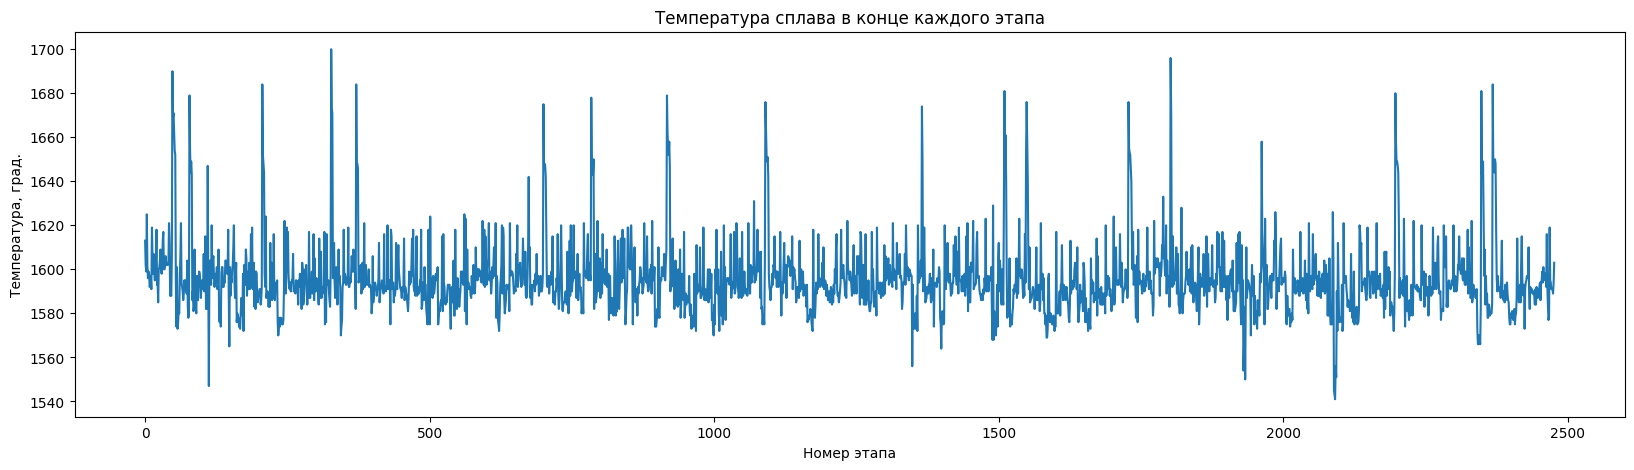

In [32]:
final_temp_grouped['last_temp'].plot(figsize=(20,5), title = 'Температура сплава в конце каждого этапа',\
                                     xlabel = 'Номер этапа', ylabel = 'Температура, град.');

#### Выводы:

По результатам предобработки информации о температуре мы избавились от аномальных значений и пропусков и подготовили датасет к объединению с другими для построения модели. На графике видно, что перегревы присутствуют и будет здорово, если наша модель научится достоверно их предсказывать и снижать их вероятность.

### Предобработка данных по электродам:

#### Общая оценка датасета и состояния данных:

Для начала переименуем столбцы датасета в соответствии с PEP8:

In [33]:
## renaming the columns names to appropriate format
arc_new.rename(columns={'Начало нагрева дугой': 'heat_start', 'Конец нагрева дугой': 'heat_end',\
                       'Активная мощность': 'active_power', 'Реактивная мощность': 'reactive_power'}, inplace=True)

Далее посмотрим на общее состояние датасета:

In [34]:
## checking the info about the dataset
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   heat_start      14876 non-null  object 
 2   heat_end        14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Видим, что у нас присутствуют данные по времени начала и окончания работы электродов. Преобразуем эти столбцы к правильному формату:

In [35]:
## converting column 'heat_start' to correct time format
arc_new['heat_start'] = pd.to_datetime(arc_new['heat_start'],format='%Y-%m-%d %H:%M:%S.%f')

In [36]:
## converting column 'heat_end' to correct time format
arc_new['heat_end'] = pd.to_datetime(arc_new['heat_end'],format='%Y-%m-%d %H:%M:%S.%f')

Сразу видно что данные у нас присутствуют все. Также можно заметить, что данные по номеру партии хранятся в float64, что избыточно. По данным активной и реактивной можности электродов оставим тип как есть, так как для него характерна дробная часть

In [37]:
## converting float64 to int32 to save memory for 'key' column
arc_new['key'] = arc_new['key'].astype('Int32')

Также посмотрим распределение данных в датасете на предмет каких-то аномальных значений:

In [38]:
## checking the dataset 'temperature' column for abnormal data
arc_new.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Видим, что у нас есть аномальное значение реактивной мощности. Его необходимо сразу удалить, так как это сильно исказит данные при будущей группировке.

#### Обработка аномальных значений:

Найдем даное аномальное значение и посмотрим к какой партии оно относится и какие еще там есть значения:

In [39]:
## selecting rows with abnormal data
arc_new.loc[arc_new['reactive_power'] < 0]

,key,heat_start,heat_end,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Видим, что это 2116 партия. Выведем её:

In [40]:
## selecting all rows from this batch
arc_new.loc[arc_new['key'] == 2116]

,key,heat_start,heat_end,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Данное аномальное значение просто удалим:

In [41]:
## dropping exact row by index
arc_new.drop([9780], inplace=True)

Еще раз перепроверим, что с данными теперь всё ок:

In [42]:
## checking that there is no more abnormal data
arc_new.describe()

,key,active_power,reactive_power
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


#### Добавление новых столбцов (признаков) и удаление избыточных

Нам необходимо из данного датасета получить данные по суммарной общей мощности нагрева и по количеству времени, которое затрачено на данный нагрев. Для этого введём дополнительные столбцы:

##### Добавление данных по общей мощности:

Мы знаем, что общая мощность рассчитывается по следующей формуле:

<b>S</b> = $\sqrt{P^2+Q^2}\$

,где S - это полная мощность, Р - активная часть, Q - реактивная часть.

Проведём необходимые вычисления и добавим в датасет новый столбец.

In [43]:
## calculating full power using the formula
arc_new['full_power'] = np.sqrt(np.square(arc_new['active_power']) + np.square(arc_new['reactive_power']))

Проверим, что новые данные добавились:

In [44]:
## checking that new column is present
arc_new.head()

,key,heat_start,heat_end,active_power,reactive_power,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934


##### Добавление данных по длительности нагрева:

Для получения длительности нагрева просто вычтем из времени окончания нагрева время его начала и переведём его в секунды, чтобы получить более менее точные значения.

In [45]:
## saving heating duration in seconds in separate column
arc_new['heating_duration'] = (arc_new['heat_end']-arc_new['heat_start']).astype('timedelta64[s]')

Проверим, всё ли ок:

In [46]:
## checking that all is OK
arc_new.head()

,key,heat_start,heat_end,active_power,reactive_power,full_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


Так как нас интересует только суммарная общая мощность потраченная на нагрев и длительность нагрева, то мы можем удалить столбцы с временем и активной\реактивной мощностями теперь:

In [47]:
## deleting obsolete columns
arc_new.drop(columns=['heat_start', 'heat_end', 'active_power', 'reactive_power'], inplace=True)

#### Приведение датасета к виду, пригодному для построения модели:

Так как мы ранее сгруппировали температурные показатели по партиям и отобрали финальное значение температуры партии, то проделаем то же самое и с данными по электродам. Однако здесь мы суммируем данные всей партии, чтобы понять сколько суммарно общей энергии потратилось на нагрев до финальной температуры:

In [48]:
## grouping rows by 'key' leaving 'key' still as a column
arc_new_grouped = arc_new.groupby('key', as_index=False).sum()

Проверим, что получилось:

In [49]:
## checking general info about grouped dataset
arc_new_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   full_power        3214 non-null   float64
 2   heating_duration  3214 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 100.4 KB


Количество строк уменьшилось на порядок, что неудивительно и посмотрим, что у нас есть в итоге:

In [50]:
## checking first 5 rows to verify the grouping
arc_new_grouped.head()

,key,full_power,heating_duration
0,1,3.718736,1098.0
1,2,2.588349,811.0
2,3,5.019223,655.0
3,4,3.400038,741.0
4,5,2.816980,869.0


Мы уже знаем, что будем предсказывать температуру и знаем, что нам пришлось отбросить некоторые этапы, где данных по температуре не было. Именно по этому мы должны и в данном датасете оставить только этапы, которые нам нужны. Подготовим датасет и отбросим лишнее:

In [51]:
## deleting the rows with 'key' value in the list of the values we do not need
arc_new_filtered = filter_rows_by_bad_keys(arc_new_grouped, 'key', bad_keys)

In [52]:
## keeping the rows with 'key' value in the list of the values we do need
arc_new_filtered_2 = filter_rows_by_good_keys(arc_new_grouped, 'key', good_keys)

Посмотрим, что получилось:

In [53]:
## general data about the filtered by bad keys dataset
arc_new_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2476 entries, 0 to 2536
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2476 non-null   int64  
 1   full_power        2476 non-null   float64
 2   heating_duration  2476 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.4 KB


In [54]:
## general data about the filtered by good keys dataset
arc_new_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2471 non-null   int64  
 1   full_power        2471 non-null   float64
 2   heating_duration  2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


Как мы видим, в том случае, где мы проводим выбор только по хорошим партиям (по которым есть значения целевого признака) данных меньше, так что будем использовать этот датасет.

#### Обработка пропусков:

Давайте еще раз посмотрим на информацию по отфильтрованным и сгруппированным данным о температуре и по также сгруппированным и отфильтрованным данным по энергии:

In [55]:
## showing info about the filtered and grouped temperature dataset
final_temp_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   key         2473 non-null   object
 1   last_temp   2473 non-null   Int32 
 2   first_temp  2473 non-null   Int32 
dtypes: Int32(2), object(1)
memory usage: 62.8+ KB


In [56]:
## showing info about the filtered and grouped arc dataset
arc_new_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2474
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2471 non-null   int64  
 1   full_power        2471 non-null   float64
 2   heating_duration  2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


Как мы можем видеть в данных по электродам не хватает 2-х партий (напомню, что после группировки - одна строка = одна партия). Почему? Возможно по ним данных по электродам не было изначально. Номера партий мы установили путём вычислений, которые тут приводить не будем чтобы не перегружать документ. Это 195 и 279. Для проверки посмотрим изначальные данные по электродам для этих партий:

In [57]:
## selecting specific rows with missing data
arc_new.loc[(arc_new['key'] == 195) |  (arc_new['key'] == 279)]

,key,full_power,heating_duration


Естественно, что и в сгруппированных и отфильтрованных данных по электродам также нет этих партий. А вот в днных по температуре есть:

In [58]:
## selecting same rows in temperature dataset to check if we have target feature information
temp_new.loc[(temp_new['key'] == 195) |  (temp_new['key'] == 279)]

,key,measurement_time,temperature
1105,195,2019-05-11 00:01:36,1583
1549,279,2019-05-14 10:13:01,1603


Любопытно, что в рамках данных партий измерение температуры проводилось всего один раз в отличии от других партий, где это делалось несколько раз. Пока оставим всё как есть, так как для данных партий ключевой признак присутствует и посмотрим, известны ли нам данные по загрузке сыпучих материалов, продувке газозом этих партий и так далее.

#### Выводы:

Мы увидели, что в данных по электродам и есть как аномальные значения, так и пропуски. Аномальные значения были убраны, но пропуски решили пока оставить как есть. Также мы сгруппировали данные и подготовили их для объединения. Вместо активной и реактивной мощности была расчитана полная. Посмотрим как выглядит теперь подготовленный датасет:

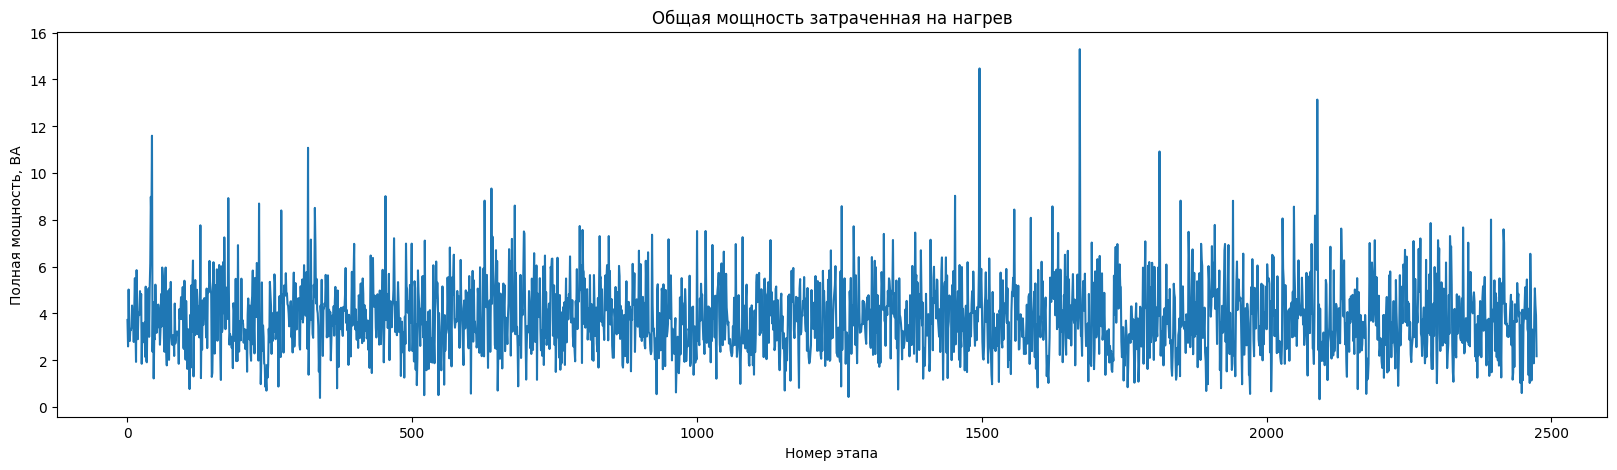

In [59]:
## plotting the graph just to visualise
arc_new_filtered_2['full_power'].plot(figsize=(20,5), title = 'Общая мощность затраченная на нагрев',\
                                     xlabel = 'Номер этапа', ylabel = 'Полная мощность, ВА');

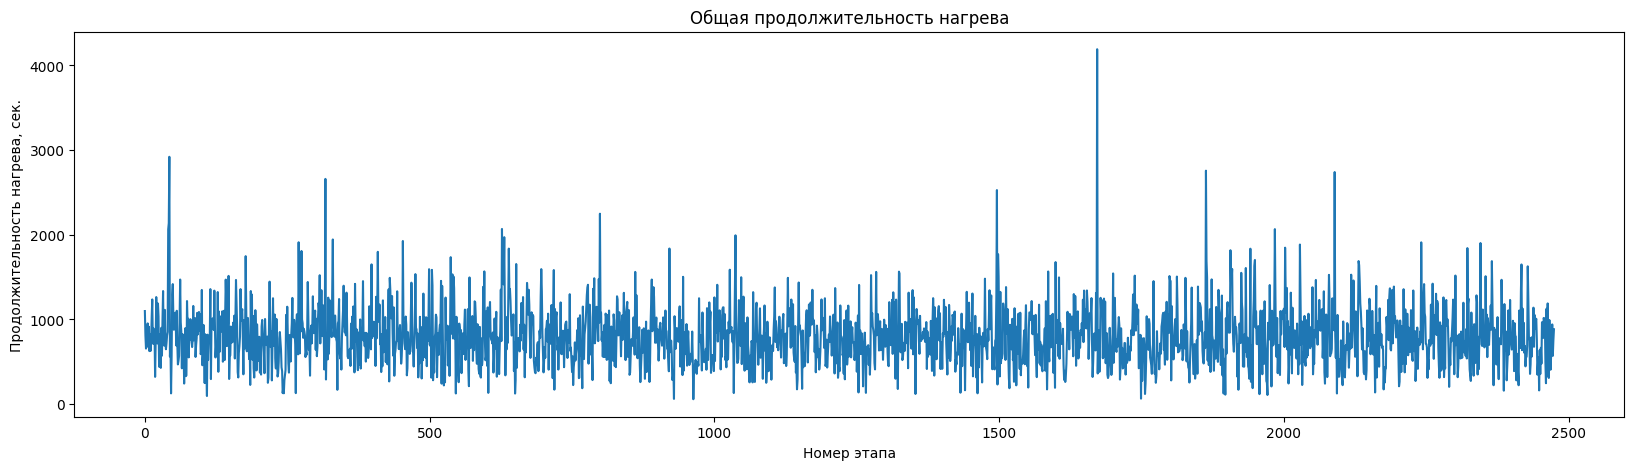

In [60]:
## plotting the graph just to visualise
arc_new_filtered_2['heating_duration'].plot(figsize=(20,5), title = 'Общая продолжительность нагрева',\
                                     xlabel = 'Номер этапа', ylabel = 'Продолжительность нагрева, сек.');

Опять же видим пики, которые нас и интересуют. Причём совпадающие, что не удивительно так как мощность нагрева напрямую связана с его длительностью. Если их предсказать, то сможем потратить меньше электричества.

### Предобработка данных по внесению сыпучих материалов:

#### Общая оценка датасета и состояния данных:

Для сыпучих материалов у нас есть 2 датасета: с временем внесения и с объёмом внесения. Время внесения для нас не играет роли, а вот объём - играет. Рассмотрим этот датасет поближе:

Для начала переименуем столбцы датасета в соответствии с PEP8:

In [61]:
## renaming the columns names to appropriate format
bulk_new.rename(columns={'Bulk 1': 'bulk_1', 'Bulk 2': 'bulk_2', 'Bulk 3': 'bulk_3', 'Bulk 4': 'bulk_4', 'Bulk 5': 'bulk_5',\
                        'Bulk 6': 'bulk_6', 'Bulk 7': 'bulk_7', 'Bulk 8': 'bulk_8', 'Bulk 9': 'bulk_9', 'Bulk 10': 'bulk_10',\
                         'Bulk 11': 'bulk_11', 'Bulk 12': 'bulk_12', 'Bulk 13': 'bulk_13',  'Bulk 14': 'bulk_14', \
                         'Bulk 15': 'bulk_15',}, inplace=True)

Далее посмотрим на общее состояние датасета:

In [62]:
## checking the info about the dataset
bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Опять же видим, что есть множество пропусков и формат данных можно хранить иначе.

In [63]:
## converting float64 to int32 to save memory for 'bulk_x' column
bulk_new['bulk_1'] = bulk_new['bulk_1'].astype('Int32')
bulk_new['bulk_2'] = bulk_new['bulk_2'].astype('Int32')
bulk_new['bulk_3'] = bulk_new['bulk_3'].astype('Int32')
bulk_new['bulk_4'] = bulk_new['bulk_4'].astype('Int32')
bulk_new['bulk_5'] = bulk_new['bulk_5'].astype('Int32')
bulk_new['bulk_6'] = bulk_new['bulk_6'].astype('Int32')
bulk_new['bulk_7'] = bulk_new['bulk_7'].astype('Int32')
bulk_new['bulk_8'] = bulk_new['bulk_8'].astype('Int32')
bulk_new['bulk_9'] = bulk_new['bulk_9'].astype('Int32')
bulk_new['bulk_10'] = bulk_new['bulk_10'].astype('Int32')
bulk_new['bulk_11'] = bulk_new['bulk_11'].astype('Int32')
bulk_new['bulk_12'] = bulk_new['bulk_12'].astype('Int32')
bulk_new['bulk_13'] = bulk_new['bulk_13'].astype('Int32')
bulk_new['bulk_14'] = bulk_new['bulk_14'].astype('Int32')
bulk_new['bulk_15'] = bulk_new['bulk_15'].astype('Int32')

Теперь посмотрим на описание данных, чтобы сразу оценить, есть ли в них аномалии:

In [64]:
## describing the data to check anomalies
bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,<NA>,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Из всего ряда выбивается только bulk_8 без std, но такой материал и вносили всего один раз. По другим сказать отклонения это или нет пока сложно. Для начала приведём датасет к виду, пригодному для построения модели и посмотрми данные еще раз.

#### Приведение датасета к виду, пригодному для построения модели:

In [65]:
## deleting the rows with 'key' value in the list of the values we do not need
bulk_new_filtered = filter_rows_by_bad_keys(bulk_new, 'key', bad_keys)

In [66]:
## keeping the rows with 'key' value in the list of the values we do need
bulk_new_filtered_2 = filter_rows_by_good_keys(bulk_new, 'key', good_keys)

In [67]:
## checking what we have as a result for bad keys
bulk_new_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2409 entries, 0 to 2469
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      2409 non-null   int64
 1   bulk_1   199 non-null    Int32
 2   bulk_2   13 non-null     Int32
 3   bulk_3   965 non-null    Int32
 4   bulk_4   815 non-null    Int32
 5   bulk_5   53 non-null     Int32
 6   bulk_6   444 non-null    Int32
 7   bulk_7   14 non-null     Int32
 8   bulk_8   1 non-null      Int32
 9   bulk_9   13 non-null     Int32
 10  bulk_10  143 non-null    Int32
 11  bulk_11  130 non-null    Int32
 12  bulk_12  1883 non-null   Int32
 13  bulk_13  14 non-null     Int32
 14  bulk_14  2138 non-null   Int32
 15  bulk_15  1714 non-null   Int32
dtypes: Int32(15), int64(1)
memory usage: 214.1 KB


In [68]:
## checking what we have as a result for good keys
bulk_new_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2404 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      2404 non-null   int64
 1   bulk_1   199 non-null    Int32
 2   bulk_2   13 non-null     Int32
 3   bulk_3   963 non-null    Int32
 4   bulk_4   813 non-null    Int32
 5   bulk_5   53 non-null     Int32
 6   bulk_6   444 non-null    Int32
 7   bulk_7   14 non-null     Int32
 8   bulk_8   1 non-null      Int32
 9   bulk_9   13 non-null     Int32
 10  bulk_10  143 non-null    Int32
 11  bulk_11  130 non-null    Int32
 12  bulk_12  1879 non-null   Int32
 13  bulk_13  14 non-null     Int32
 14  bulk_14  2134 non-null   Int32
 15  bulk_15  1710 non-null   Int32
dtypes: Int32(15), int64(1)
memory usage: 213.6 KB


Опять же мы видим, что после удаления партий, для которых нам не известна температура мы в остатке получили 2409 партий. А вот для которых известна - таких 2404. А температура нам известна для 2471 партий. Так что мы всё еще имеем пропуски в данных, но я думаю, что тут можно просто считать, что добавляли 0 сыпучих материалов. Разберёмся с этим после объединения. Но использовать для объединения будем датасет bulk_new_filtered_2

#### Обработка пропусков:

Каждый пропуск в данных об оъёме сыпучих материалов просто говорит, что объёма не было. Он равен 0. Так и заполним недостающие данные:

In [69]:
## filling NaN with 0
bulk_new_filtered_2.fillna(0, inplace=True)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


#### Обработка аномальных значений:

После удаления партий, который нас не интересуют и заполнения пропусков мы можем оценить полученный датасет на аномалии:

In [70]:
## checking dataset description for abnormal data
bulk_new_filtered_2.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,1250.839850,3.320715,1.378120,45.986273,36.227953,2.557820,22.004576,1.961730,0.020383,0.430948,4.895175,4.112729,209.099418,1.034110,153.873128,116.962978
std,716.938995,12.231430,18.783601,74.527544,58.174666,22.054702,55.262318,30.209688,0.999376,6.123284,20.607519,22.173628,156.339610,14.012378,81.940968,85.634213
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,630.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1252.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,106.000000
75%,1867.250000,0.000000,0.000000,76.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.250000,0.000000,204.000000,204.000000
max,2499.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Особых аномалий, на которые следует обратить внимание не выявлено.

#### Выводы:

Мы отобрали в данном датасете также данные по партиям, которые нас интересуют. Аномалий после отбрасывания лишних партий не выявлено. Пропуски были заполнены. 

### Предобработка данных по внесению проволочных материалов:

#### Общая оценка датасета и состояния данных:

Для проволочных материалов у нас есть 2 датасета: с временем внесения и с объёмом внесения. Время внесения для нас не играет роли, а вот объём - играет. Рассмотрим этот датасет поближе:

Для начала переименуем столбцы датасета в соответствии с PEP8:

In [71]:
## renaming the columns names to appropriate format
wire_new.rename(columns={'Wire 1': 'wire_1', 'Wire 2': 'wire_2', 'Wire 3': 'wire_3', 'Wire 4': 'wire_4', 'Wire 5': 'wire_5',\
                         'Wire 6': 'wire_6', 'Wire 7': 'wire_7', 'Wire 8': 'wire_8', 'Wire 9': 'wire_9'}, inplace=True)

Далее посмотрим на общее состояние датасета:

In [72]:
## checking the info about the dataset
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Опять же видим, что есть множество пропусков, однако формат данных мы менять не будем так как нам реально необходимо хранить дробную часть.

Теперь посмотрим на описание данных, чтобы сразу оценить, есть ли в них аномалии:

In [73]:
wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Опять же - по данным сказать есть ли отклонения или нет пока сложно. Для начала приведём датасет к виду, пригодному для построения модели и посмотрми данные еще раз.

#### Приведение датасета к виду, пригодному для построения модели:

In [74]:
## deleting the rows with 'key' value in the list of the values we do not need
wire_new_filtered = filter_rows_by_bad_keys(wire_new, 'key', bad_keys)

In [75]:
## keeping the rows with 'key' value in the list of the values we do need
wire_new_filtered_2 = filter_rows_by_good_keys(wire_new, 'key', good_keys)

In [76]:
## checking what we have as a result
wire_new_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2374 entries, 0 to 2434
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2374 non-null   int64  
 1   wire_1  2350 non-null   float64
 2   wire_2  833 non-null    float64
 3   wire_3  39 non-null     float64
 4   wire_4  12 non-null     float64
 5   wire_5  0 non-null      float64
 6   wire_6  45 non-null     float64
 7   wire_7  4 non-null      float64
 8   wire_8  13 non-null     float64
 9   wire_9  28 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 204.0 KB


In [77]:
wire_new_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2369 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2369 non-null   int64  
 1   wire_1  2345 non-null   float64
 2   wire_2  831 non-null    float64
 3   wire_3  39 non-null     float64
 4   wire_4  12 non-null     float64
 5   wire_5  0 non-null      float64
 6   wire_6  45 non-null     float64
 7   wire_7  4 non-null      float64
 8   wire_8  13 non-null     float64
 9   wire_9  28 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 203.6 KB


Опять же мы видим, что после удаления партий, для которых нам не известна температура мы получили 2374 партии, а при сохранении партий, для которых она известна мы в остатке получили 2369 партии. Меньше даже чем для сыпучих материалов. Так что мы опять имеем пропуски в данных, но я думаю, что тут можно просто считать, что добавляли 0 проволочных материалов и мы с этим сможем разобраться после объединения данных. Выбираем второй датасет, с теми данными, для которых есть целевой признак.

#### Обработка пропусков:

Каждый пропуск в данных об оъёме проволочных материалов просто говорит, что их не было. Он равен 0. Так и заполним недостающие данные:

In [78]:
## filling NaN with 0
wire_new_filtered_2.fillna(0, inplace=True)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#### Обработка аномальных значений:

После удаления партий, который нас не интересуют и заполнения пропусков мы можем оценить полученный датасет на аномалии:

In [79]:
## checking dataset description for abnormal data
wire_new_filtered_2.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.0,2369.000000,2369.000000,2369.000000,2369.000000
mean,1250.785564,102.232002,17.845112,3.180295,0.301374,0.0,0.962293,0.006253,0.306055,0.414843
std,716.424280,43.627466,33.957245,27.708997,4.717556,0.0,8.620486,0.203962,4.365548,4.334396
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,628.000000,72.961197,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1254.000000,101.075520,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1869.000000,128.138393,23.150400,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,90.053604


Особых аномалий, на которые следует обратить внимание не выявлено.

#### Выводы:

Мы отобрали в данном датасете также данные по партиям, которые нас интересуют. Аномалий после отбрасывания лишних партий не выявлено. Пропуски были заполнены. 

### Предобработка данных по продувке газом:

#### Общая оценка датасета и состояния данных:

Для начала переименуем столбцы датасета в соответствии с PEP8:

In [80]:
## renaming the columns names to appropriate format
gas_new.rename(columns={'Газ 1': 'gas_1'}, inplace=True)

Далее посмотрим на общее состояние датасета:

In [81]:
## checking the info about the dataset
gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В данном датасете мы видим, что пропусков нет и формат данных мы менять опять же не будем так как нам реально необходимо хранить дробную часть.

Теперь посмотрим на описание данных, чтобы сразу оценить, есть ли в них аномалии:

In [82]:
gas_new.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Опять же - по данным сказать есть ли отклонения или нет пока сложно. Для начала приведём датасет к виду, пригодному для построения модели и посмотрми данные еще раз.

#### Приведение датасета к виду, пригодному для построения модели:

In [83]:
## deleting the rows with 'key' value in the list of the values we do not need
gas_new_filtered = filter_rows_by_bad_keys(gas_new, 'key', bad_keys)

In [84]:
## keeping the rows with 'key' value in the list of the values we do need
gas_new_filtered_2 = filter_rows_by_good_keys(gas_new, 'key', good_keys)

In [85]:
## checking rows with 'key' minus bad_keys
gas_new_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2501 entries, 0 to 3204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2501 non-null   int64  
 1   gas_1   2501 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 58.6 KB


In [86]:
## checking rows with 'key' in good_keys
gas_new_filtered_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2471 non-null   int64  
 1   gas_1   2471 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 57.9 KB


А вот тут уже ситуация странная. Если удалять партии, по которым у нас нет данных о температуре, то мы видим, что в остатке число партий составляет 2501, что <b>больше</b> чем число партий с известной температурой. А если оставлять только партии про которые мы точно знаем температуру, то таких чуть <b>меньше</b>. Можно сделать вывод, что в первом случае в данном датасете есть партии, которых вообще нет в датасете про температуру. Она для них не то, чтобы неизвестна - про эти партии вообще нет никаких данных. Нам такая информация ничем тоже не поможет, так что будем ориентироваться на вывод второй функции, которая показывает только партии, для которых данные по температуре точно есть.

#### Обработка пропусков:

Как мы могли видеть в прошлой части, разница в количестве партий для датасета с температурой и продувкой газом составляет также 2 значения (как и ранее в датасете с данными по электродам). Номера партий мы установили опять путём вычислений, которые тут приводить не будем чтобы не перегружать документ. Это 193 и 259. Для проверки посмотрим изначальные данные обоих датасетов для этих партий:

In [87]:
gas_new_filtered_2.loc[(gas_new_filtered_2['key'] == 193) |  (gas_new_filtered_2['key'] == 259)]

,key,gas_1


Естественно, что в данных п обработке газом  нет этих партий. А вот в днных по температуре есть:

In [88]:
final_temp_grouped.loc[(final_temp_grouped['key'] == 193) |  (final_temp_grouped['key'] == 259)]

,key,last_temp,first_temp
190,193,1595,1593
256,259,1590,1577


Что и требовалось проверить. После объединения датасетов мы посмотрим, чем можно заполнить подобные пропуски.

#### Обработка аномальных значений:

После оставления данных только по партиям, которые нас интересуют, мы можем оценить полученный датасет на аномалии:

In [89]:
## checking dataset description for abnormal data
gas_new_filtered_2.describe()

,key,gas_1
count,2471.000000,2471.000000
mean,1250.492918,11.139788
std,720.097263,6.328796
min,1.000000,0.008399
25%,628.500000,7.102961
50%,1252.000000,9.925930
75%,1872.500000,13.872453
max,2499.000000,77.995040


Особых аномалий, на которые следует обратить внимание не выявлено.

#### Выводы:

В данном датасете мы видим, что были данне по партиям, которые не были представлены в датасете по температуре. После предобработки, мы оставили только необходимые данные. Аномальных значений не выявлено и можно двигаться далее.

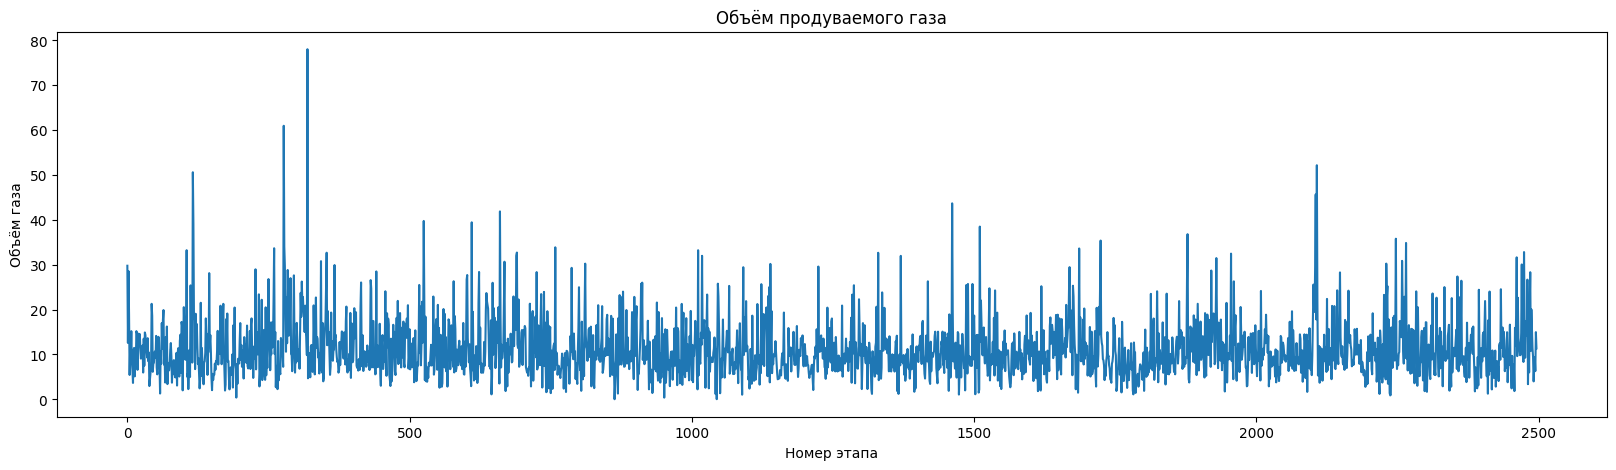

In [90]:
gas_new_filtered_2['gas_1'].plot(figsize=(20,5), title = 'Объём продуваемого газа',\
                                     xlabel = 'Номер этапа', ylabel = 'Объём газа');

Можно видеть, что выбросами можно считать данные по активной мощности более 1,4, но они не совпадают с флуктуациями температуры по колонке id, так что аномальные значения по температуре скорее всего просто ошибка измереня датчика и я их бы удалил. Равно как и выброс по Реактивной мощности в -715 ед. измерения.

### Получение объединённого датасета для обучения модели.

#### Объединение датасетов:

После того, как данные были предобработаны, объединим их в один датасет для последующего использования. Для объединения используем:
- final_temp_grouped - объединенные и сгруппированные данные по партиям и финальной температуре партии
- arc_new_filtered_2 - объединённые данные по полной можности затраченной на нагрев до финальной температуры партии
- bulk_new_filtered_2 - данные по сыпучим материалам для каждой партии
- wire_new_filtered_2 - данные по проволочным материалам
- gas_new_filtered_2 - данные по продувке газом для тех этапов, по которым есть данные по температуре

In [91]:
## joining the first 2 datasets
final_1 = final_temp_grouped.join(arc_new_filtered_2.set_index('key'), on='key', how='inner')

In [92]:
## adding data about bulk materials
final_2 = final_1.join(bulk_new_filtered_2.set_index('key'), on='key', how='inner')

In [93]:
## adding data about wire materials
final_3 = final_2.join(wire_new_filtered_2.set_index('key'), on='key', how='inner')

In [94]:
## getting the final dataset by adding data about gas
final_data = final_3.join(gas_new_filtered_2.set_index('key'), on='key', how='inner')

In [95]:
final_data

,key,last_temp,first_temp,full_power,heating_duration,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,gas_1
0,1,1613,1571,3.718736,1098.0,0,0,0,43,0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1602,1581,2.588349,811.0,0,0,0,73,0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1599,1596,5.019223,655.0,0,0,0,34,0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1625,1601,3.400038,741.0,0,0,0,81,0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1602,1576,2.816980,869.0,0,0,0,78,0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,2495,1591,1570,3.868721,723.0,0,0,21,0,0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2473,2496,1591,1554,5.070316,940.0,0,0,0,63,0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2474,2497,1589,1571,4.360918,569.0,0,0,0,85,0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2475,2498,1594,1591,3.909917,750.0,0,0,90,0,0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


#### Исследование объединённого датасета:

После того, как мы объединили данные, исследуем полученный датасет:

In [96]:
## checking info about summary dataset
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2476
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2325 non-null   object 
 1   last_temp         2325 non-null   Int32  
 2   first_temp        2325 non-null   Int32  
 3   full_power        2325 non-null   float64
 4   heating_duration  2325 non-null   float64
 5   bulk_1            2325 non-null   Int32  
 6   bulk_2            2325 non-null   Int32  
 7   bulk_3            2325 non-null   Int32  
 8   bulk_4            2325 non-null   Int32  
 9   bulk_5            2325 non-null   Int32  
 10  bulk_6            2325 non-null   Int32  
 11  bulk_7            2325 non-null   Int32  
 12  bulk_8            2325 non-null   Int32  
 13  bulk_9            2325 non-null   Int32  
 14  bulk_10           2325 non-null   Int32  
 15  bulk_11           2325 non-null   Int32  
 16  bulk_12           2325 non-null   Int32  


Пропусков нет. Всё готово для моделирования.

##### Создание нового индекса:

Так как у нас номера партий теперь уникальны и отдельной колонкой они нам не нужны, то превратим этот столбец в индексы суммарного датасета:

In [97]:
## changing the index of the dataset to values from one of the column
final_data = final_data.set_index('key')

### Общий вывод по предобработке:

В целом, мы получили общий датасет с полностью заполненными пропусками и без аномалий и готовы переходить к моделированию. У нас осталось 2329 партии, для которых известен целевой признак и мы отобрали остальные данные основываясь на этом.

## Построение моделей прогнозирования:

Для того, чтобы мы могли построить модели регресии для начала проанализируем данные дополнительно на предмет мультиколлинеарности.

### Анализ данных на мультиколлинеарность:

Так как мы будем решать задачу регресии, а мультиколлинеарность в регрессионном анализе может вызвать проблемы при подгонке и интерпретации регрессионной модели и возникает, когда две или более переменных-предикторов сильно коррелируют друг с другом, так что они не предоставляют уникальную или независимую информацию в регрессионной модели, то проведём анализ на неё. Для этого построим матрицу корреляции:

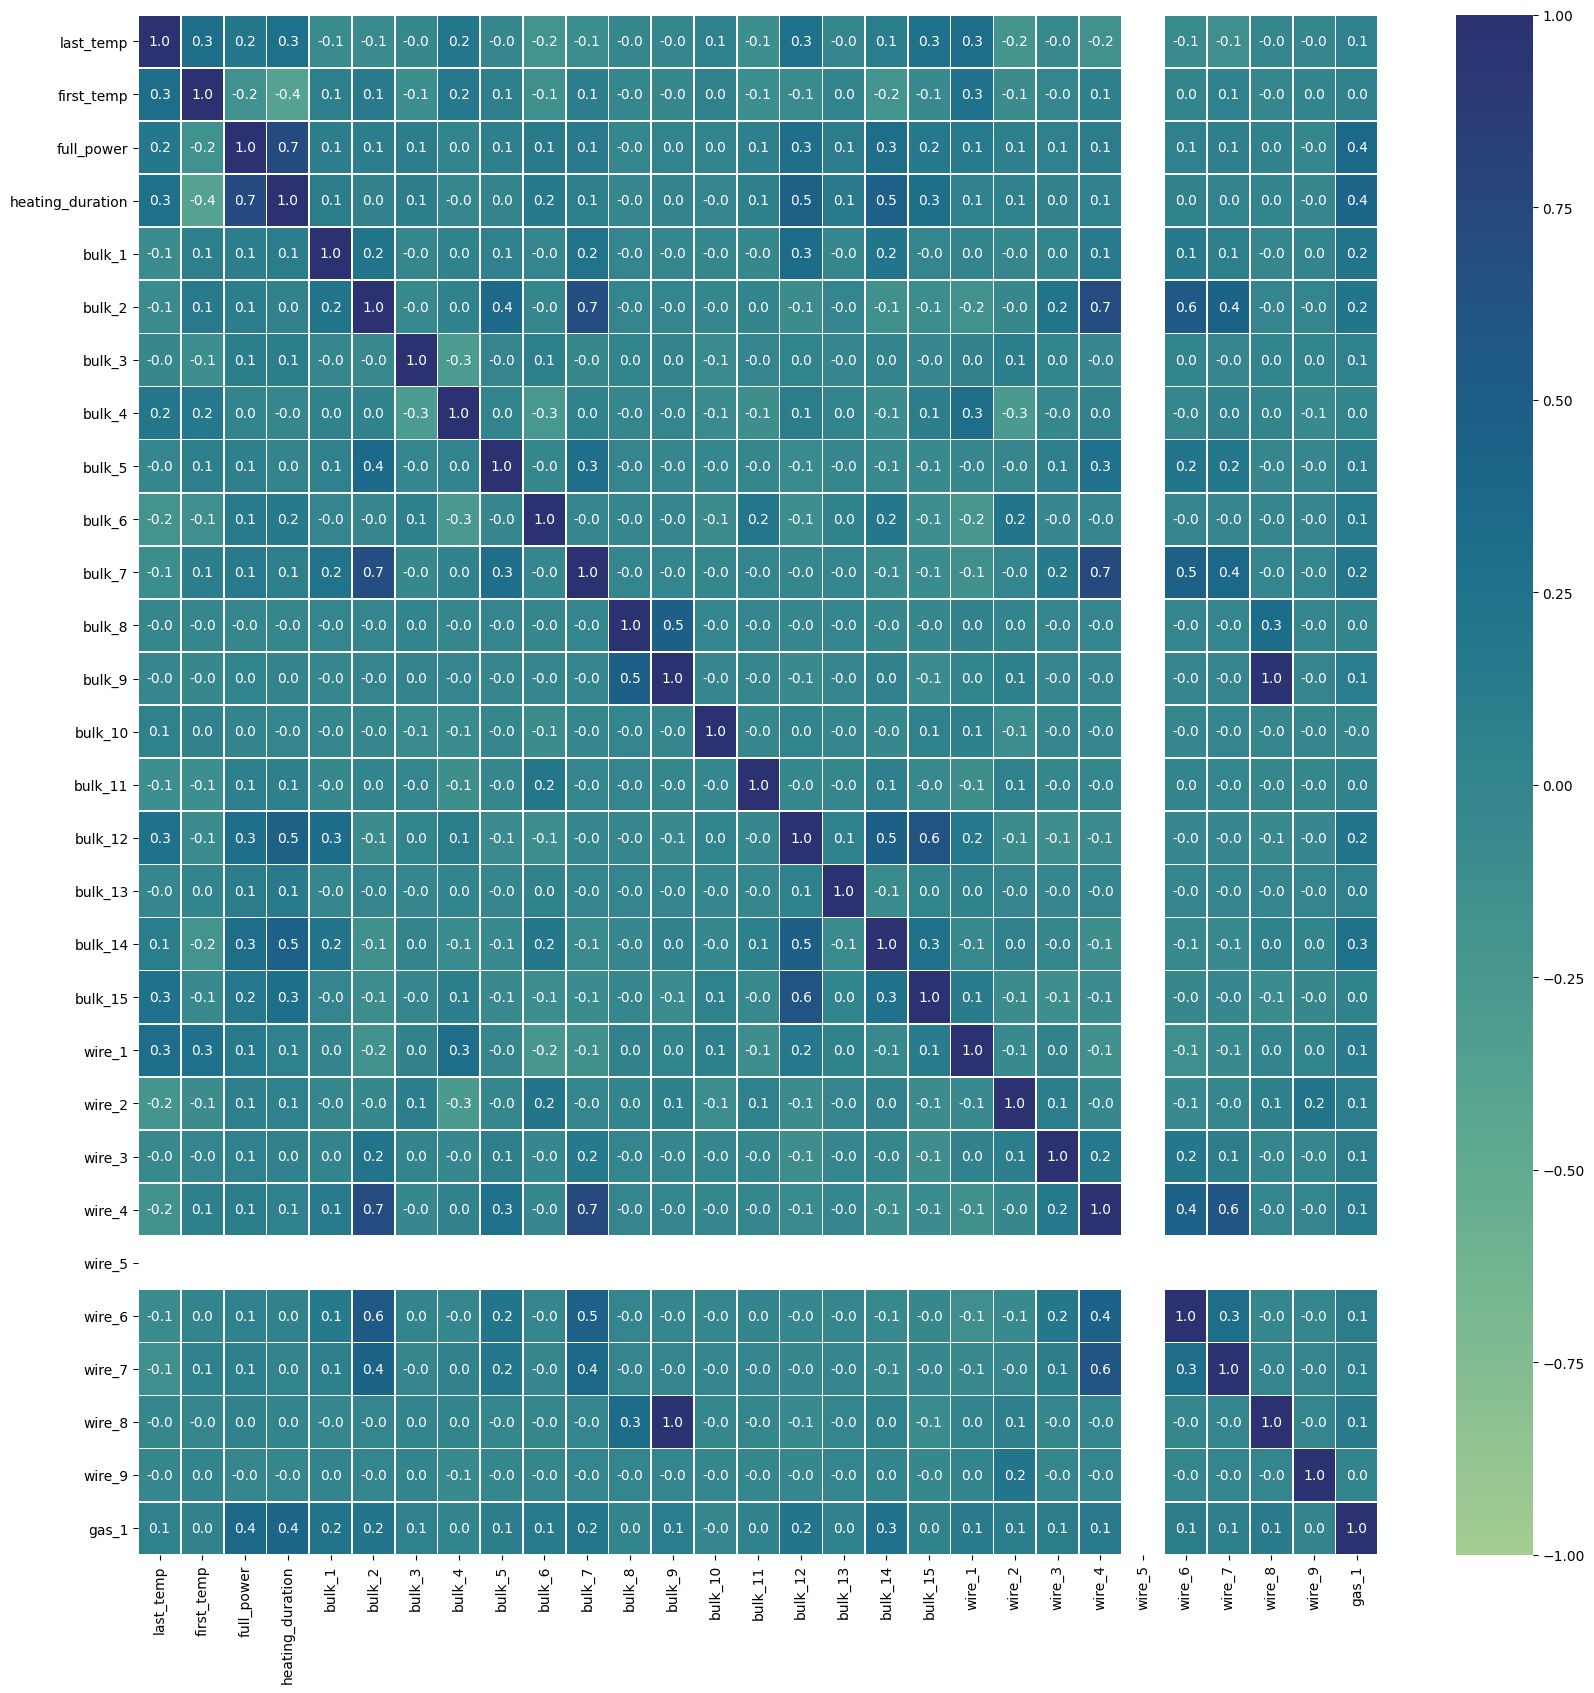

In [98]:
## plotting the heatmap for correlation
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(final_data.corr(), ax=ax, annot=True, cmap="crest", fmt=".1f", linewidth=.5, vmin = -1, vmax = +1);

Как мы можем видеть, сильной корреляцией между собой обладают признаки wire_8 и bulk_9. Посмотрим, сколько значений было у данных признаков в изначальных данных, чтобы решить, можем ли мы избавится от них:

In [99]:
## checking how much data we have in 'wire_8' column
wire_new_filtered_2['wire_8'].count()

2369

In [100]:
## checking how much data we have in 'bulk_8' column
bulk_new_filtered_2['bulk_9'].count()

2404

И там и там по 13 значений, так что нет разницы какие данные удалять. Удалим данные по проволоке.

In [101]:
## deleting one of the heavily correlated columns
del final_data['wire_8']

Также отдельно посмотрим корреляцию признаков с ключевым признаком - температурой:

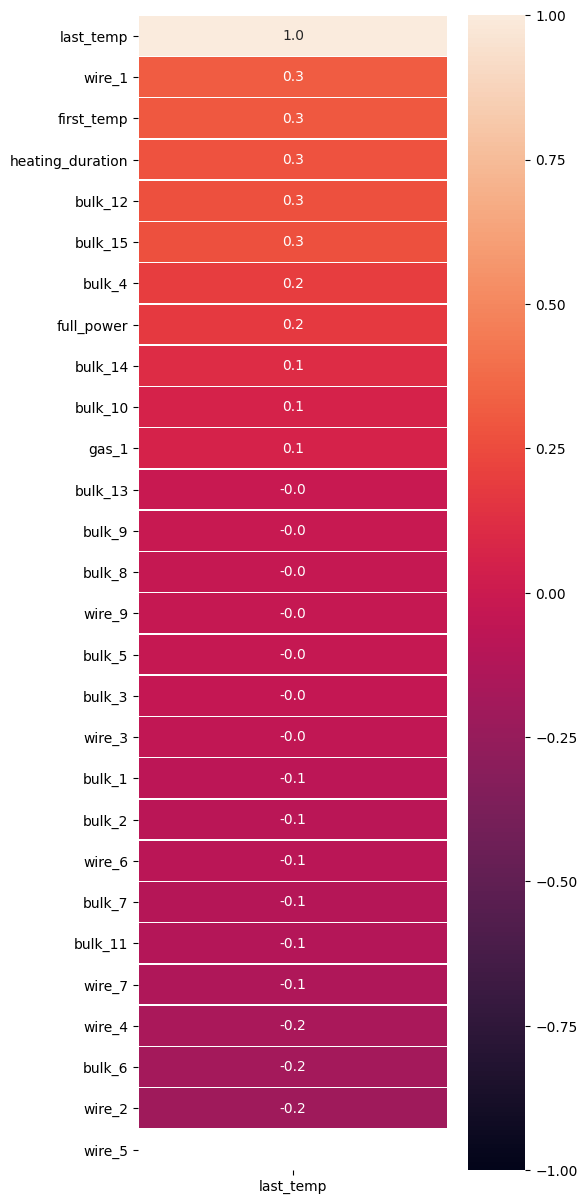

In [102]:
## showing the correlation between the key feature and the rest of the features
corr = final_data.corr()[['last_temp']].sort_values(by='last_temp', ascending=False)
plt.figure(figsize = (5,15))
sns.heatmap(corr, annot=True, fmt=".1f", linewidth=.5, vmin = -1, vmax = +1);

Как мы видим - какой-то существенной корреляции нет. Особенно после удаления данных этапом выше. Можно работать далее.

### Масштабирование данных и получение обучающей и тестовой выборки:

Предсказывая температуру по имеющимся данным мы решаем задачу регрессии для которой хорошо бы отмасштабировать данные так как они могут на порядок отличаться друг от друга. Например полная мощность и количество сыпучих материалов. Но, начннём с того, что разобъем наш датасет на выборки с которыми потом будем работать.

#### Подготовка обучающей, валидационной и тестовой выборок:

Так как мы пытаемся предсказать температуру в конце партии, то целевым признаком выбираем 'temperature'.

In [103]:
# saving features of the dataset in the separate dataset
features = final_data.drop(['last_temp'], axis=1) 

In [104]:
# saving key feature of the dataset in the separate dataset
target = final_data['last_temp']

Получив два датасета с ключевым признаком и остальными признаками разобъём их на 2 части по 75% и 25%.

In [105]:
# splitting the main dataset on 2 parts: 0.6 and 0.4 for training and validation+test purposes
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=100723)

Теперь просто посмотрим на получившиеся 2 датасета (тех, например, что содержат не ключевые признаки), чтобы убедиться, что они разбиты правильно:

In [106]:
# checking new datasets shape to verify that splitting went good
print(features_train.shape)
print(features_test.shape)

(1743, 27)
(582, 27)


После того, как выборки получены - можно переходить к масштабированию данных.

#### Масштабирование данных:

Взглянем на наши данные еще раз, чтобы понять, необходимо ли их масштабировать.

In [107]:
#showing the data from the train dataset
features_train.head(10)

,first_temp,full_power,heating_duration,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_9,gas_1
key,,,,,,,,,,,,,,,,,,,,,
2046,1600,8.056621,1883.0,0,0,80,242,0,0,0,...,209,116.014073,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,14.113083
59,1589,3.725705,1101.0,29,0,0,0,0,87,0,...,205,40.141922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.279322
991,1589,4.305503,632.0,0,0,38,0,0,0,0,...,102,96.969597,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.922912
75,1606,2.042588,329.0,0,0,0,141,0,0,0,...,0,114.266884,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.434558
1156,1627,3.091093,499.0,0,0,0,40,0,0,0,...,0,55.083599,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.537058
295,1597,2.330022,335.0,0,0,0,151,0,0,0,...,205,110.160957,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,6.256595
992,1632,1.928510,396.0,0,0,0,0,0,0,0,...,102,56.160000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,11.541988
414,1575,4.653719,776.0,0,0,70,0,0,0,0,...,204,128.185211,37.187283,0.0,0.0,0.0,0.0,0.0,0.0,7.227394
956,1574,5.001573,960.0,0,0,31,0,0,0,0,...,104,138.574791,135.388229,0.0,0.0,0.0,0.0,0.0,0.0,15.597803


Можно сразу отметить, что данные о полной мощности отличаются на порядок от объёма сыпучих материалов или объёма газа, не говоря уже про остальное. Так что проведём масштабирование.

In [108]:
# calling the scaler
scaler = StandardScaler()

In [109]:
# training the scaler
scaler.fit(features_train)

StandardScaler()

In [110]:
# transforming the training data by the trained scaler
features_train_scaled = scaler.transform(features_train)

In [111]:
# transforming the test data by the trained scaler
features_test_scaled = scaler.transform(features_test)

После того, как данные были кодированы и масштабированы, можно наконец переходить к обучению моделей.

### Обучение моделей

Предлагается проверить три модели и перед нами стоит задача предсказания регресии, так что для сравнения предлагаются следующие модели:

- LinearRegression
- Ridge
- RandomForestRegressor
- LightGBM
- Catboost

Для оценки качества моделей применим метрику MAE. По просьбе бизнеса она не должна быть более 6.8. Для сохранения результатов качества предсказания моделей на тренировочных данных и выбора лучшей создадим отдельный датасет:

In [112]:
# creating the dataframe to store MAE score for models
result_data = pd.DataFrame(index=['train_mae_score'],\
                     columns=['linear_regression', 'ridge', 'random_forest_regressor', 'light_gbm', 'catboost'])

#### Модель LinearRegression:

Модель линейной регресии достаточно простая и у неё особо нет параметров для подбора. Так что инициализируем её, обучим и проверим кросс-валидацией какое значение MAE можно ожидать от модели.

In [113]:
## initialising linear regression model
lr_model = LinearRegression()

In [114]:
## saving MAE scores of the model with 10 cross validations
scores = cross_val_score(lr_model, features_train, target_train, scoring='neg_mean_absolute_error', cv=5)

C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renami

In [115]:
## calculation the final score
final_score = sum(-scores)/5
final_score

6.337069978945864

Как мы можем судить, средняя ошибка модели составляет около 6.34 и она уже меньше, чем требования заказчика. Сохраним значение в нашей таблице результатов и перейдём всё же к другим моделям.

##### Результат обучения:

In [116]:
# adding best MAE score from LinearRegression models
result_data.loc['train_mae_score', 'linear_regression'] = round(final_score, 2)
result_data

,linear_regression,ridge,random_forest_regressor,light_gbm,catboost
train_mae_score,6.34,NaN,NaN,NaN,NaN


#### Модель Ridge:

Данная модель регресии является популярной для небольших наборов данных, как у нас, и отличается от модели линейной регресси тем, что борется с переобучением модели.  Так что инициализируем её, обучим, подберём параметры и посмотрим какое значение MAE можно ожидать от модели.

##### Подбор гиперпараметров модели:

In [117]:
## initialising Ridge regression model
rg_model = Ridge()

In [118]:
# setting the hyperparameters to find best ones
rg_param = {'alpha':range(1,50)}

In [119]:
# Trying to choose best hyperparameters for the model comparing them via MAE metric
best_rg = GridSearchCV (rg_model, param_grid = rg_param, n_jobs=-1, verbose=10, \
                        scoring = 'neg_mean_absolute_error', cv=5)

In [120]:
# calculating the best hyperparameters
best_rg.fit(features_train_scaled, target_train)
print(best_rg.best_params_)
print(-best_rg.best_score_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
{'alpha': 33}
6.325340510935752


Как мы можем судить, средняя ошибка модели составляет также около 7.33 чуть лучше чем в простой модели регресии. И опять же меньше, чем в требовании заказчика. Сохраним значение в нашей таблице результатов и перейдём к другим моделям.

##### Результат обучения:

In [121]:
# adding best MAE score from LinearRegression models
result_data.loc['train_mae_score', 'ridge'] = round(-best_rg.best_score_, 2)
result_data

,linear_regression,ridge,random_forest_regressor,light_gbm,catboost
train_mae_score,6.34,6.33,NaN,NaN,NaN


#### Модель RandomForestRegressor

##### Подбор гиперпараметров модели:

Для подборки гиперпараметров данной модели воспользуемся GridSearchCV. Для начала инициализируем модель:

In [122]:
# initializing the model
rfr_model = RandomForestRegressor(random_state=100723)

Теперь укажем гиперпараметры из которых будем искать наиболее подходящие:

In [123]:
# setting the hyperparameters to find best ones
rfr_param = {'n_estimators': range(1,300,10), 'max_depth': range(1,15)}

In [124]:
# Trying to choose best hyperparameters for the model comparing them via MAE metric
best_rfr = GridSearchCV (rfr_model, param_grid = rfr_param, n_jobs=-1, verbose=10, \
                        scoring = 'neg_mean_absolute_error', cv=5)

In [125]:
# calculating the best hyperparameters
best_rfr.fit(features_train_scaled, target_train)
print(best_rfr.best_params_)
print(-best_rfr.best_score_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
{'max_depth': 9, 'n_estimators': 21}
6.312582056517115


Как мы можем судить, средняя абсолютная ошибка модели составляет около 6.31. Меньше, чем требования заказчика и меньше, чем у модели линейной регрессии и Ridge. Сохраним  данные и перейдём к другим моделям.

##### Результат обучения:

In [126]:
# adding best MAE score from RandomScoreRegressor model
result_data.loc['train_mae_score', 'random_forest_regressor'] = round(-best_rfr.best_score_, 2)
result_data

,linear_regression,ridge,random_forest_regressor,light_gbm,catboost
train_mae_score,6.34,6.33,6.31,NaN,NaN


#### Модель LightGBM

##### Подбор гиперпараметров:

Для подбора гиперпараметров модели опять воспользуемся GridSearchCV. Подготовим параметры с которыми будем проверять модель:

In [127]:
# settings for hyperparameters selections
parameters = {
     'task' : ['predict'],
     'boosting': ['gbdt'],
     'objective': ['mean_absolute_error'],
     'num_iterations': [500, 1000, 1500],
     'learning_rate':[0.01, 0.05, 0.001],
     'num_leaves':[7, 15, 31],
     'max_depth' :[5, 10],
     'min_data_in_leaf':[15, 25],
     'feature_fraction': [0.6, 0.8, 0.9],
     'bagging_fraction': [0.6, 0.8],
     'bagging_freq': [100, 200, 400]}

Далее объявим саму модель и запустим подбор гиперпараметров для неё.

In [128]:
# model initializing
lgb_model = lgb.LGBMRegressor(random_state=100723)

In [129]:
# starting the hyperparameters selection
best_lgbm = GridSearchCV(lgb_model, param_grid = parameters, n_jobs=-1, verbose=10, \
                        scoring = 'neg_mean_absolute_error', cv=5)

In [130]:
# fitting the model with selected parameters and shoosing the best one with better RMSE score 
best_lgbm.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=100723), n_jobs=-1,
             param_grid={'bagging_fraction': [0.6, 0.8],
                         'bagging_freq': [100, 200, 400], 'boosting': ['gbdt'],
                         'feature_fraction': [0.6, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.001],
                         'max_depth': [5, 10], 'min_data_in_leaf': [15, 25],
                         'num_iterations': [500, 1000, 1500],
                         'num_leaves': [7, 15, 31],
                         'objective': ['mean_absolute_error'],
                         'task': ['predict']},
             scoring='neg_mean_absolute_error', verbose=10)

In [131]:
# showing the selected best hyperparameters
print(best_lgbm.best_params_)
print(-best_lgbm.best_score_)

{'bagging_fraction': 0.6, 'bagging_freq': 100, 'boosting': 'gbdt', 'feature_fraction': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'min_data_in_leaf': 25, 'num_iterations': 1500, 'num_leaves': 31, 'objective': 'mean_absolute_error', 'task': 'predict'}
6.102411828020137


Как мы можем судить, средняя абсолютная ошибка модели составляет около 6.1 и она гораздо меньше, чем требования заказчика и метрики остальных ранее протестированных моделей. Рассмотрим последнюю модель.

##### Результат обучения:

In [132]:
# adding best MAE score from LightGBM model
result_data.loc['train_mae_score', 'light_gbm'] = round(-best_lgbm.best_score_, 2)
result_data

,linear_regression,ridge,random_forest_regressor,light_gbm,catboost
train_mae_score,6.34,6.33,6.31,6.1,NaN


#### Модель Catboost

Для подбора гиперпараметров модели опять воспользуемся GridSearchCV. Подготовим параметры с которыми будем проверять модель:

##### Подбор гиперпараметров:

In [133]:
# settings for hyperparameters selections
parameters = {'depth': range(1,10),
              'learning_rate' : [0.01, 0.05, 0.001],
              'iterations': range(1,200,10)
             }

In [134]:
# model initializing
cbr_model = CatBoostRegressor(random_state=100723)

In [135]:
# starting the hyperparameters selection
best_cbr = GridSearchCV(cbr_model, param_grid = parameters, n_jobs=-1, verbose=10, \
                        scoring = 'neg_mean_absolute_error', cv=5)

In [136]:
# fitting the model with selected parameters and shoosing the best one with better RMSE score 
best_cbr.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
0:	learn: 10.9576827	total: 138ms	remaining: 26.1s
1:	learn: 10.8329907	total: 139ms	remaining: 13.1s
2:	learn: 10.7112670	total: 140ms	remaining: 8.8s
3:	learn: 10.5760428	total: 141ms	remaining: 6.61s
4:	learn: 10.4921939	total: 143ms	remaining: 5.3s
5:	learn: 10.3808791	total: 144ms	remaining: 4.43s
6:	learn: 10.2698506	total: 145ms	remaining: 3.81s
7:	learn: 10.1774333	total: 146ms	remaining: 3.35s
8:	learn: 10.0781263	total: 147ms	remaining: 2.98s
9:	learn: 9.9917575	total: 149ms	remaining: 2.69s
10:	learn: 9.8903565	total: 150ms	remaining: 2.45s
11:	learn: 9.8198734	total: 151ms	remaining: 2.25s
12:	learn: 9.7529413	total: 152ms	remaining: 2.08s
13:	learn: 9.6754192	total: 153ms	remaining: 1.94s
14:	learn: 9.5972526	total: 154ms	remaining: 1.81s
15:	learn: 9.5319586	total: 155ms	remaining: 1.7s
16:	learn: 9.4683519	total: 156ms	remaining: 1.6s
17:	learn: 9.4069845	total: 158ms	remaining: 1.51s
18:	learn: 9.3433415	to

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000012834861790>,
             n_jobs=-1,
             param_grid={'depth': range(1, 10), 'iterations': range(1, 200, 10),
                         'learning_rate': [0.01, 0.05, 0.001]},
             scoring='neg_mean_absolute_error', verbose=10)

In [137]:
# showing the selected best hyperparameters
print(best_cbr.best_params_)
print(-best_cbr.best_score_)

{'depth': 6, 'iterations': 191, 'learning_rate': 0.05}
6.236371263778457


Как мы можем судить, средняя абсолютная ошибка модели составляет около 6.24 и она меньше, чем требования заказчика, но больше, чем для LightGBM. 

##### Результат обучения:

In [138]:
# adding best MAE score from Catboost model
result_data.loc['train_mae_score', 'catboost'] = round(-best_cbr.best_score_, 2)
result_data

,linear_regression,ridge,random_forest_regressor,light_gbm,catboost
train_mae_score,6.34,6.33,6.31,6.1,6.24


### Выбор лучшей модели.

Посмотрим еще раз на данные по результатам моделей:

In [139]:
result_data

,linear_regression,ridge,random_forest_regressor,light_gbm,catboost
train_mae_score,6.34,6.33,6.31,6.1,6.24


Видим, что лучший результат показала модель Light GBM. Выберем её для использования на тестовых данных.

## Проверка выбранной модели на тестовых данных и анализ признаков.

### Проверка лучшей модели на тестовых данных:

Еще раз инициализируем модель выбрав лучшие подобранные гиперпараметры и посмотрим на её результат на тестовых данных:

In [140]:
# model initializing
final_model = lgb.LGBMRegressor(bagging_fraction=0.6, bagging_freq=100, boosting='gbdt', feature_fraction=0.9,\
                                learning_rate=0.01, max_depth=5, min_data_in_leaf=25, num_iterations=1500,\
                                num_leaves=31, objective='mean_absolute_error', task='predict', random_state=100723)

In [141]:
# fitting the final model on the train data
final_model.fit(features_train_scaled, target_train)

C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(bagging_fraction=0.6, bagging_freq=100, boosting='gbdt',
              feature_fraction=0.9, learning_rate=0.01, max_depth=5,
              min_data_in_leaf=25, num_iterations=1500,
              objective='mean_absolute_error', random_state=100723,
              task='predict')

In [142]:
%%time
## making predictions and saving it
predictions = final_model.predict(features_test_scaled)

CPU times: total: 266 ms
Wall time: 4 ms


In [143]:
## calculating MAE
print(mean_absolute_error(target_test, predictions))

6.183311149778382


C:\Users\Mello\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


#### Вывод

Модель показала результат MAE 6.18. Это меньше, чем требовалась заказчику и время предсказания также было менее 1 секунды, что очень хорошо. Модель можно рекомендовать к использованию.

### Анализ важности признаков модели:

Проведём анализ важности признаков для полученной нами модели.

In [144]:
## saving info about feature importance from the model
feature_importance = final_model.feature_importances_

In [145]:
# sorting the featues
sorted_idx = np.argsort(feature_importance)

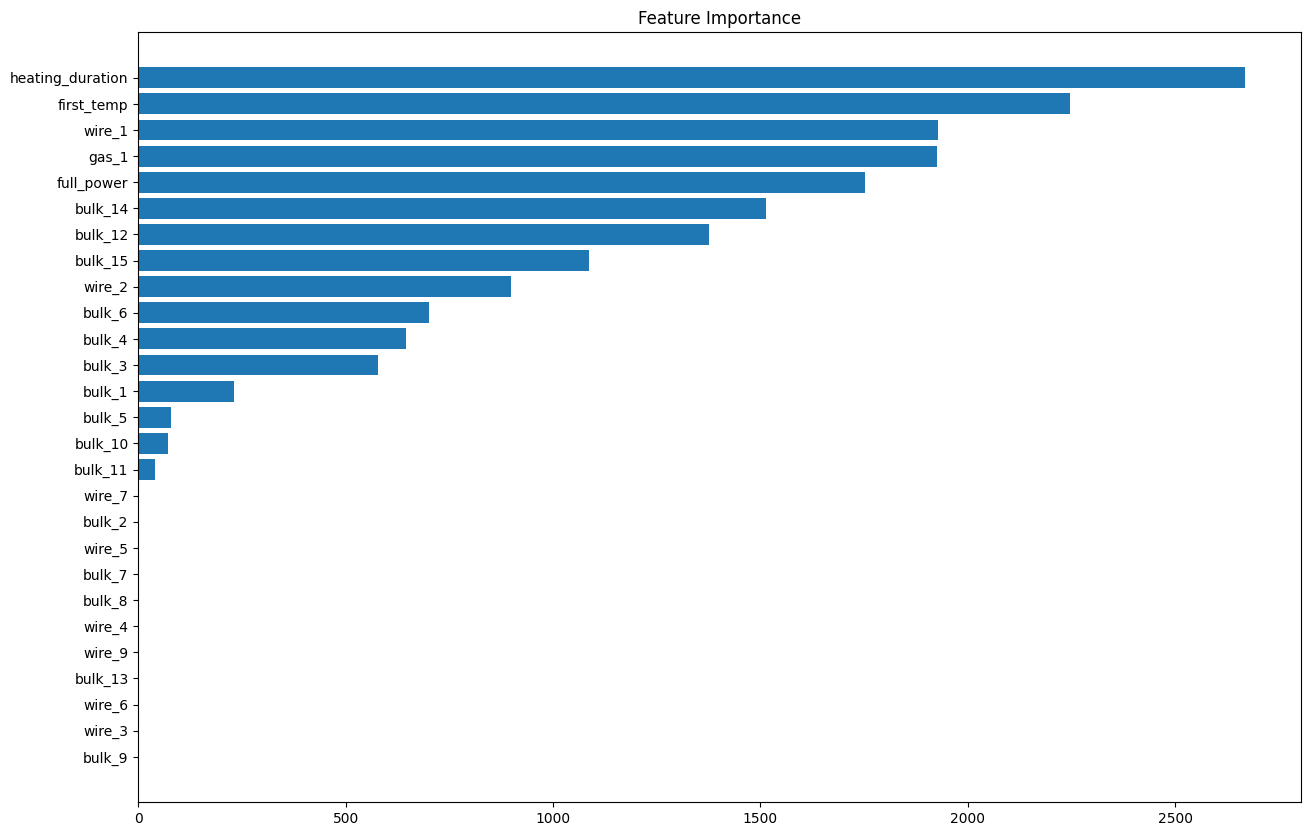

In [146]:
## plotting the information about features importance
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance');

По результатам анализа можно сделать вывод, что на температуру крайне сильно влияет длительность нагрева (что неудивительно), температура подачи ковша в начале этапа, внесение wire_1 и продувка газом. Необходимо обратить внимание на то с какой температурой подаётся ковш на этап и не добускать чрезмерного остывания. Продувку газом также необходимо совершенствовать и собрать данные по её времени. Если на конечный продукт влияет не время, я объём газа, возможно целесообразно интенсифицировать внесение. Необходимы дополнительные данные.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 4</b></u></p>
ОК, Игнат, теперь можно сказать, что пройден весь алгоритм моделирования от анализа исходной инфо до анализа важности факторов.<br> Увидел твои комментари/коорректировки, принято. А на курсе всего не уместить. Поэтому наставники и тимлиды призваны дополнять тренажёр)<br>
 
 
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
Это было отступление)<br>    
Тогда впереди только отчёт. Что для него важно - оставлял в презентации. <br>
БУДУ ЖДАТЬ! <br>